<a href="https://colab.research.google.com/github/sydney-machine-learning/sentimentanalysis-USelections/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using LSTM and Keras

In [ ]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import tensorflow as tf
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/US_elections/LSTM/IMDB Dataset.csv')

print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:

import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load and Clean Dataset
In the original dataset, the reviews are still dirty. There are still html tags, numbers, uppercase, and punctuations. This will not be good for training, so in load_dataset() function, beside loading the dataset using pandas, I also pre-process the reviews by removing html tags, non alphabet (punctuations and numbers), stop words, and lower case all of the reviews.

## Encode Sentiments
In the same function, I also encode the sentiments into integers (0 and 1). Where 0 is for negative sentiments and 1 is for positive sentiments.

In [ ]:
def load_dataset():
    df = pd.read_csv('/content/drive/MyDrive/US_elections/LSTM/IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


## Split Dataset


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
33282    [i, know, slashers, always, supposed, bad, com...
38418    [this, movie, bad, i, know, begin, apparently,...
14178    [thanks, killing, franchise, turkey, john, car...
33857    [movie, made, watch, paul, w, s, anderson, avp...
43719    [i, think, probably, one, worst, movies, i, wa...
                               ...                        
26229    [this, picture, hit, movie, screens, june, th,...
38580    [the, best, thing, camp, films, general, know,...
4497     [as, long, go, movie, understanding, going, co...
7269     [this, movie, stupid, hate, turned, reached, h...
9957     [i, actually, went, see, movie, low, expectati...
Name: review, Length: 40000, dtype: object 

18524    [no, lifeforce, great, movie, it, good, movie,...
46492    [unfortunately, one, best, efforts, yet, made,...
12398    [i, love, called, blaxploitation, films, seen,...
34083    [i, watched, plenty, times, i, planning, buyin...
5210     [ok, last, night, i, saw, world, premiere, pau...
 

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

## Tokenize and Pad/Truncate Reviews

A Neural Network only accepts numeric data, so we need to encode the reviews. I use tensorflow.keras.preprocessing.text.Tokenizer to encode the reviews into integers, where each unique word is automatically indexed (using fit_on_texts method) based on x_train.
x_train and x_test is converted into integers using texts_to_sequences method.

Each reviews has a different length, so we need to add padding (by adding 0) or truncating the words to the same length (in this case, it is the mean of all reviews length) using tensorflow.keras.preprocessing.sequence.pad_sequences.

post, pad or truncate the words in the back of a sentence
pre, pad or truncate the words in front of a sentence

In [ ]:
print(x_train)
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

33282    [i, know, slashers, always, supposed, bad, com...
38418    [this, movie, bad, i, know, begin, apparently,...
14178    [thanks, killing, franchise, turkey, john, car...
33857    [movie, made, watch, paul, w, s, anderson, avp...
43719    [i, think, probably, one, worst, movies, i, wa...
                               ...                        
26229    [this, picture, hit, movie, screens, june, th,...
38580    [the, best, thing, camp, films, general, know,...
4497     [as, long, go, movie, understanding, going, co...
7269     [this, movie, stupid, hate, turned, reached, h...
9957     [i, actually, went, see, movie, low, expectati...
Name: review, Length: 40000, dtype: object
Encoded X Train
 [[   1   46 6644 ...   27   17   10]
 [   8    3   19 ...   79   61 1106]
 [1159  754 2850 ...  271 4680  354]
 ...
 [ 107  101   62 ...    0    0    0]
 [   8    3  276 ...    0    0    0]
 [   1   74  320 ...    0    0    0]] 

Encoded X Test
 [[  257  8780    21 ...     0     0     0]
 [

## Build Architecture/Model

**Embedding Layer:** in simple terms, it creates word vectors of each word in the word_index and group words that are related or have similar meaning by analyzing other words around them.

**LSTM Layer:** to make a decision to keep or throw away data by considering the current input, previous output, and previous memory. There are some important components in LSTM.

- **Forget Gate**, decides information is to be kept or thrown away
- Input Gate, updates cell state by passing previous output and current input into sigmoid activation function
- **Cell State**, calculate new cell state, it is multiplied by forget vector (drop value if multiplied by a near 0), add it with the output from input gate to update the cell state value.
- **Ouput Gate**, decides the next hidden state and used for predictions

**Dense Layer:** compute the input with the weight matrix and bias (optional), and using an activation function. I use Sigmoid activation function for this work because the output is only 0 or 1.

The optimizer is Adam and the loss function is Binary Crossentropy because again the output is only 0 and 1, which is a binary number.

In [ ]:
from tensorflow.keras.utils import plot_model
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
plot_model(model, to_file='/content/drive/MyDrive/US_elections/LSTM/modelLSTM.png')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           2948384   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,977,441
Trainable params: 2,977,441
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/US_elections/LSTM/LSTM_2.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - 20s 36ms/step - loss: 0.5609 - accuracy: 0.6473

Epoch 00001: accuracy improved from -inf to 0.77410, saving model to /content/drive/MyDrive/US_elections/LSTM/LSTM_2.h5
Epoch 2/5
313/313 [==============================] - 11s 36ms/step - loss: 0.1871 - accuracy: 0.9326

Epoch 00002: accuracy improved from 0.77410 to 0.92948, saving model to /content/drive/MyDrive/US_elections/LSTM/LSTM_2.h5
Epoch 3/5
313/313 [==============================] - 11s 36ms/step - loss: 0.1013 - accuracy: 0.9686

Epoch 00003: accuracy improved from 0.92948 to 0.96562, saving model to /content/drive/MyDrive/US_elections/LSTM/LSTM_2.h5
Epoch 4/5
313/313 [==============================] - 11s 36ms/step - loss: 0.0563 - accuracy: 0.9835

Epoch 00004: accuracy improved from 0.96562 to 0.97975, saving model to /content/drive/MyDrive/US_elections/LSTM/LSTM_2.h5
Epoch 5/5
313/313 [==============================] - 11s 36ms/step - loss: 0.0514 - accuracy: 0.9844

E


## Testing

To evaluate the model, we need to predict the sentiment using our **x_test** data and comparing the predictions with y_test (expected output) data. Then, we calculate the accuracy of the model by dividing numbers of correct prediction with the total data. Resulted an accuracy of **86.63%**

In [ ]:

y_pred = model.predict_classes(x_test, batch_size = 128)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Correct Prediction: 8658
Wrong Prediction: 1342
Accuracy: 86.58


## Load Saved Model

Load saved model and use it to predict a movie review statement's sentiment (positive or negative)

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/US_elections/LSTM/LSTM.h5')

Receives a review as an input to be predicted

In [ ]:
review = str(input('Movie Review: '))

Movie Review: Nothing was typical about this. Everything was beautifully done in this movie, the story, the flow, the scenario, everything. I highly recommend it for mystery lovers, for anyone who wants to watch a good movie!


The input must be pre processed before it is passed to the model to be predicted

In [ ]:
# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

Cleaned:  Nothing was typical about this Everything was beautifully done in this movie the story the flow the scenario everything I highly recommend it for mystery lovers for anyone who wants to watch a good movie
Filtered:  ['nothing typical everything beautifully done movie story flow scenario everything i highly recommend mystery lovers anyone wants watch good movie']


In [ ]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[  76  680  169 1188  125    3   15 2651 2642  169    1  444  285  706
  1721  151  400   34    9    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [ ]:
result = loaded_model.predict(tokenize_words)
print(result)

[[0.99802494]]


In [ ]:
if result >= 0.7:
    print('positive')
else:
    print('negative')

positive


# Testing this on tweet data

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences


!pip install transformers command
from transformers import BertTokenizer, TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

     |████████████████████████████████| 1.8MB 15.5MB/s 
     |████████████████████████████████| 890kB 44.1MB/s 
     |████████████████████████████████| 2.9MB 54.8MB/s 
  Created wheel for command: filename=Command-0.1.0-cp36-none-any.whl size=6406 sha256=aceed2257756ff61a270c6d4d4405b6607b54400d548c28f760b8b7093af8bd5
  Stored in directory: /root/.cache/pip/wheels/6b/61/e7/7e78f4d431de4a7d1f83af33f599d0bfe03e65fe3ff1ad73c5
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6372e273b728bfbf7042d8ce941fb11ba9ea8aba8f4997f84ea169a57aaa9ac8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built command sacremoses


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/US_elections/LSTM/LSTM.h5')

In [ ]:
biden_df = pd.read_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_biden.csv')
trump_df = pd.read_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_trump.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'

balance_data_df = pd.DataFrame(columns=trump_df.columns)
balance_data_df

,user_id,tweet,long,lat,state_code,sentiment,who


In [ ]:
states_list = set(biden_df['state_code']).union(set(trump_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])

In [ ]:
for state in states_list:
    trump_df_state = trump_df[trump_df['state_code']==state]
    biden_df_state = biden_df[biden_df['state_code']==state]
    
    n_sample = len(trump_df_state) if len(trump_df_state) < len(biden_df_state) else len(biden_df_state)
    
    if len(trump_df_state) < len(biden_df_state):
        balance_data_df = pd.concat([balance_data_df, trump_df_state])
        balance_data_df = pd.concat([balance_data_df, biden_df_state.sample(len(trump_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, biden_df_state])
        balance_data_df = pd.concat([balance_data_df, trump_df_state.sample(len(biden_df_state))])

In [ ]:
balance_data_df

,user_id,tweet,long,lat,state_code,sentiment,who
0,1081.0,finally FoxNews just called it for Biden,-122.0322895,37.3229,CA,0.0,trump
11,10727.0,biden beats trump. Talk about a relaxing way t...,-122.4199061,37.779,CA,0.0,trump
15,29283.0,"Trump mentioned Motown in MI today, but Motow...",-122.4199061,37.779,CA,0.0,trump
25,647253.0,Fully agree! You can dislike Bidens politics h...,-122.2713563,37.8045,CA,0.0,trump
27,682223.0,This week... JoeBiden JOEBIDEN2020 JoeBiden...,-122.4199061,37.779,CA,0.0,trump
...,...,...,...,...,...,...,...
44862,198313485.0,TheRealFixNow The DOJ has said the laptop is c...,-80.4363743,33.6874,SC,0.0,trump
44868,198313485.0,"Their crazed, mind controlled masses are turni...",-80.4363743,33.6874,SC,0.0,trump
128625,1.2641824959873477e+18,BarackObama ReallyAmerican1 JoeBiden KamalaHar...,-78.89004090000002,33.6956,SC,0.0,trump
120406,1.156761495272903e+18,Att CNN MSNBC CBSNews NBCNews ABC NewsHour nyt...,-80.4363743,33.6874,SC,0.0,trump


In [ ]:
batch_size = 100

In [ ]:
from tqdm.auto import tqdm
import tensorflow as tf

def emotion_classify(tweet_list):
    batch_idx = np.append(np.arange(0, len(tweet_list), batch_size), len(tweet_list))
    labels = np.array([])
    for i in tqdm(range(len(batch_idx)-1)):
        tf_batch = tokenizer(tweet_list[batch_idx[i]:batch_idx[i+1]], max_length=280, padding=True, truncation=True, return_tensors='tf')
        tf_outputs = model(tf_batch)
        tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
        labels = np.append(labels, tf.argmax(tf_predictions, axis=1))
#         labels = np.append(labels, tf_predictions[:,1])
        del tf_batch
    return labels

In [ ]:
# vocabulary_size = 20000
# tokenizer = Tokenizer(num_words= vocabulary_size)
# tokenizer.fit_on_texts(balance_data_df['tweet'])
# sequences = tokenizer.texts_to_sequences(balance_data_df['tweet'])
# data = pad_sequences(sequences, maxlen=50)

In [ ]:
balance_data_df['sentiment'] = emotion_classify(list(balance_data_df['tweet']))


In [ ]:
balance_data_df.to_csv('/content/drive/MyDrive/US_elections/LSTM/balance_data_with_sentiments.csv', index=False, header=True)

balance_data_df.head()

,user_id,tweet,long,lat,state_code,sentiment,who
0,1081.0,finally FoxNews just called it for Biden,-122.0322895,37.3229,CA,1.0,trump
11,10727.0,biden beats trump. Talk about a relaxing way t...,-122.4199061,37.779,CA,1.0,trump
15,29283.0,"Trump mentioned Motown in MI today, but Motow...",-122.4199061,37.779,CA,1.0,trump
25,647253.0,Fully agree! You can dislike Bidens politics h...,-122.2713563,37.8045,CA,1.0,trump
27,682223.0,This week... JoeBiden JOEBIDEN2020 JoeBiden...,-122.4199061,37.779,CA,1.0,trump


In [ ]:
dem_states = set(['DC', 'VT', 'HI', 'MA', 'MD', 'CA', 'NY', 'RI', 'DE', 
                 'CT', 'WA', 'ME', 'NJ', 'OR', 'IL'])
rep_states = set(['OH', 'IA', 'TX', 'MT', 'SC', 'AK', 'MO', 'IN', 'NE',
                 'KS', 'UT', 'MS', 'TN', 'SD', 'KY', 'LA', 'AL', 'ND',
                 'ID', 'AR', 'OK', 'WV', 'WY'])
swing_states = states_list - dem_states - rep_states

In [ ]:
electoral_vote_by_state = pd.read_csv('/content/drive/MyDrive/US_elections/electoral_vote_by_state.csv')

In [ ]:
states_results = pd.DataFrame(columns=['state_code', 'biden', 'trump', 'type', 'winner'])

In [ ]:
states_results.loc[:,'state_code'] = electoral_vote_by_state['state_code']
states_results.loc[:,'e_vote'] = electoral_vote_by_state['e_vote']

In [ ]:
type_vs_candidate = {'blue': 'biden', 'red': 'trump', 'purple': 'contentious'}
threshold = 1.15
for state in states_list:
    trump_slice = balance_data_df.query(f'state_code == "{state}" and who == "trump"')
    biden_slice = balance_data_df.query(f'state_code == "{state}" and who == "biden"')
    trump_score = np.sum(trump_slice['sentiment']) + 1
    biden_score = np.sum(biden_slice['sentiment']) + 1
    
    state_type = ''
    if state in dem_states:
        state_type = 'blue'
    elif state in rep_states:
        state_type = 'red'
    else:
        state_type = 'purple'
        
    winner = ''
    if len(trump_slice) + len(biden_slice) < 1000:
        winner = type_vs_candidate[state_type]
    else:
        if trump_score/biden_score > threshold:
            winner = 'trump'
        elif biden_score/trump_score > threshold:
            winner = 'biden'
        else:
            winner = 'contentious'
        
    states_results.loc[states_results['state_code'] == state, ['biden', 'trump', 'type', 'winner']] = \
        [biden_score, trump_score, state_type, winner]

In [ ]:
states_results.query('winner=="contentious"')


,state_code,biden,trump,type,winner,e_vote
0,AL,793,791,red,contentious,9
4,AZ,2642,2648,purple,contentious,11
5,NV,2087,2087,purple,contentious,6
7,NH,258,257,purple,contentious,4
8,CA,23581,23685,blue,contentious,55
9,NJ,3566,3569,blue,contentious,14
10,CO,2407,2459,purple,contentious,9
11,NM,426,430,purple,contentious,5
12,CT,832,831,blue,contentious,7
13,NY,17185,17248,blue,contentious,29


In [ ]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt

us_shape = gpd.read_file('/content/drive/MyDrive/US_elections/us_shape/cb_2018_us_state_20m.shp')
us_shape = us_shape[['STUSPS', 'geometry']]
states_results_tmp = states_results.copy()
states_results_tmp = states_results_tmp.merge(us_shape, left_on='state_code', right_on='STUSPS')
states_results_tmp.drop(['STUSPS'], axis=1, inplace=True)
states_results_tmp = gpd.GeoDataFrame(states_results_tmp)

states_results_tmp.columns

     |████████████████████████████████| 972kB 22.4MB/s 
     |████████████████████████████████| 14.8MB 221kB/s 
     |████████████████████████████████| 6.5MB 44.3MB/s 


Index(['state_code', 'biden', 'trump', 'type', 'winner', 'e_vote', 'geometry'], dtype='object')

[]

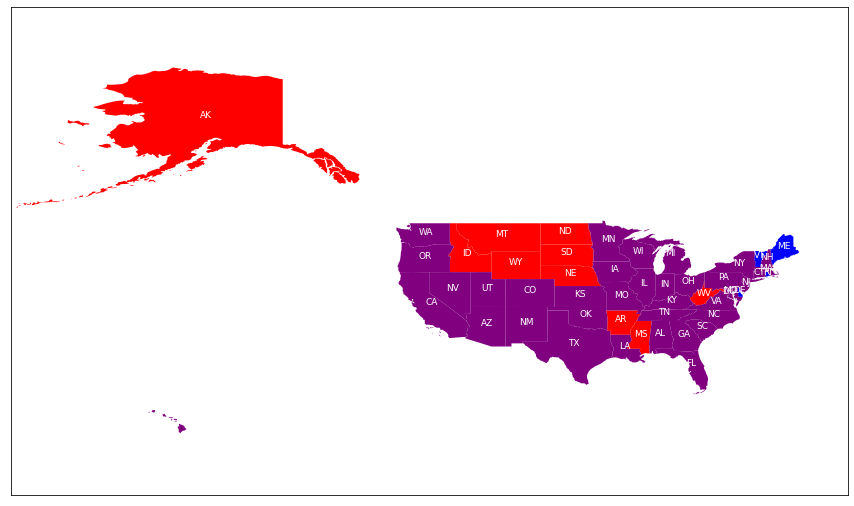

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
states_results_tmp.apply(lambda x: ax.annotate(s=x.state_code, xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, color='white'),axis=1);
states_results_tmp[states_results_tmp['winner'] == 'trump'].plot(ax=ax, color='red')
states_results_tmp[states_results_tmp['winner'] == 'biden'].plot(ax=ax, color='blue')
states_results_tmp[states_results_tmp['winner'] == 'contentious'].plot(ax=ax, color='purple')
plt.axis('square')
ax.set_xlim([-180, -60])
ax.set_ylim([10, 80])
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
states_results.to_csv('/content/drive/MyDrive/US_elections/state_results_LSTM.csv', index=False, header=True)
fig.savefig('/content/drive/MyDrive/US_elections/state_results_LSTM.png')

In [ ]:
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

41 14
